In [1]:
!pip install cplex
!pip install docplex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43.3 MB 21 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 610 kB 4.8 MB/s 
  Created wheel for docplex: filename=docplex-2.23.222-py3-none-any.whl size=662847 sha256=79fce3e4dff8162bb097b69d093eb4e9d845096d0eae7e7d2bff7c48e275d150
  Stored in directory: /root/.cache/pip/wheels/a7/c9/fb/cee5a89f304e77a39c466e625ac2830434b76eb8384999d116
Successfully built docplex


In [2]:
import matplotlib.pyplot as plt
import docplex.mp.model as md
from itertools import permutations
import numpy as np
import time
import random

In [3]:
def neighbors(I,n):
  N=np.zeros((n,n))
  for i in range(n):
    for j in range(n):
      if i==0 and j==0:
       N[i][j]=I[i+1][j]+I[i+1][j+1]+I[i][j+1]  #add neighbors explicitly
      elif i==0 and 0<j<n-1:
        N[i][j]=I[i+1][j-1]+I[i+1][j]+I[i+1][j+1]+I[i][j+1]+I[i][j-1]
      elif i==0 and j==n-1:
        N[i][j]=I[i+1][j]+I[i+1][j-1]+I[i][j-1]
      elif j==0 and 0<i<n-1:
        N[i][j]=I[i-1][j+1]+I[i][j+1]+I[i+1][j+1]+I[i+1][j]+I[i-1][j]
      elif j==0 and i==n-1:
        N[i][j]=I[i][j+1]+I[i-1][j+1]+I[i-1][j]
      elif i==n-1 and 0<j<n-1:
        N[i][j]=I[i][j-1]+I[i][j+1]+I[i-1][j-1]+I[i-1][j]+I[i-1][j+1]
      elif j==n-1 and 0<i<n-1:
        N[i][j]=I[i-1][j]+I[i+1][j]+I[i-1][j-1]+I[i][j-1]+I[i+1][j-1]
      elif i==n-1 and j==n-1:
        N[i][j]=I[i-1][j]+I[i-1][j-1]+I[i][j-1]
      elif 0<i<n-1 and 0<j<n-1:
        N[i][j]=I[i-1][j-1]+I[i-1][j]+I[i-1][j+1]+I[i][j-1]+I[i][j+1]+I[i+1][j-1]+I[i+1][j]+I[i+1][j+1]
    
  for i in range(n):
    for j in range(n):
      if (N[i][j]<2 or N[i][j]>3) and I[i][j]==1:
        N[i][j]=10
      elif (N[i][j]==2 or N[i][j]==3) and I[i][j]==1:
        N[i][j]=2.5
      elif N[i][j]==3 and I[i][j]==0:
        N[i][j]=3
      else:
        N[i][j]=0
  return N

In [4]:
np.random.seed(45)

Set Initial Board

First Iteration

In [5]:
n=5
I=np.array([[random.randint(0,1) for i in range(n)]   for j in range(n)]).reshape(n,n)
print('I:\n',I)
N=neighbors(I,n)
print('Neighbors:\n',N)

I:
 [[1 1 0 0 0]
 [1 0 0 1 0]
 [1 0 1 0 1]
 [0 0 1 0 0]
 [1 0 1 0 0]]
Neighbors:
 [[ 2.5  2.5  0.   0.   0. ]
 [ 2.5  0.   3.   2.5  0. ]
 [10.   0.   2.5  0.  10. ]
 [ 0.   0.   2.5  0.   0. ]
 [10.   3.  10.   0.   0. ]]


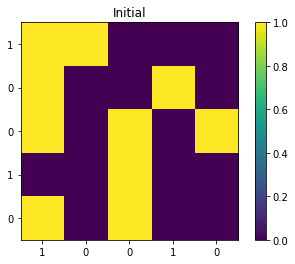

In [6]:
plt.imshow(I, interpolation='nearest',cmap='viridis')
plt.yticks([i for i in range(n)],I[1][:])
plt.xticks([i for i in range(n)],I[1][:])
plt.title('Initial')
plt.colorbar()
plt.show()

The rules are:

1. Live cells with $<2$ live neighbors die (underpopulated)
2. Live cells with $>3$ live neighbors die (overpopulated)
3. Live cells with $2$ or $3$ live neighbors live.
4. Dead cells with $3$ live neighbors come to life.

We can write our original intuition as something like
$$H_{gol} = - \underbrace{\sum_{ij} \left(1 - N_{ij} x_{ij}  I_{ij}  \right)^2}_{\text{Condition $\#1$}} - \underbrace{\sum_{ij} \left(4 - N_{ij} x_{ij} I_{ij}  \right)^2}_{\text{Condition $\#2$}} + \underbrace{\sum_{ij} \left( 2.5 - N_{ij} x_{ij} I_{ij} \right)^2}_{\text{Condition $\#3$ where $2,3$ have the same penalty of $0.5^2$}} +  \underbrace{\sum_{ij} \left[ 3 - N_{ij} x_{ij} (1-I_{ij}) \right]^2}_{\text{Condition $\#4$}} $$


The matrix $I_{ij}$ is the initial configuration of spins. Thus, $1-I_{ij}$ gives the spins that are turned off a value of $1$ instead. The matrix $N_{ij}$ describes the neighbors of the initial cells. In $N$, the dead cells with less than $3$ live neighbors have a value of $0$, the dead cells with exactly $3$ live neighbors have a value of $3$, the live cells with $2$ or $3$ live neighbors have a value of $2.5$, and the live cells with an overpopulation or underpopulation go to the same value of $10$. The value of $10$ is to enforce that it does not matter if a cell is underpopulated or overpopulated, it should die either way. 

The revised Hamiltonian should reduce to
$$H_{gol} = - \underbrace{\sum_{ij} \left(10-N_{ij} x_{ij} I_{ij}  \right)^2}_{\text{Combine condition $\#2$ and $\# 1$
}} + (weight)*\sum_{ij} \left( 2.5 - N_{ij} x_{ij} I_{ij} \right)^2  + \sum_{ij} \left[ 3 - N_{ij} x_{ij} (1-I_{ij}) \right]^2 $$
where we have added a weight factor to the second term to ensure that reguardless of the third term's value, condition $\#3$ will always be satisfied, as well.

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


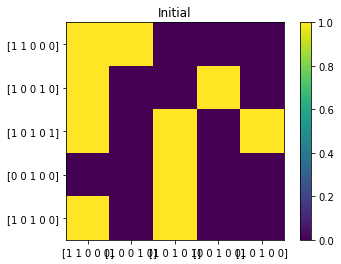

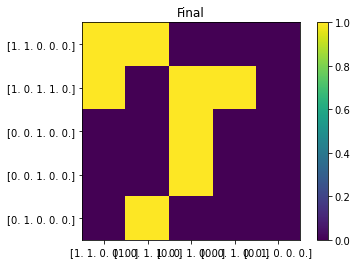

In [7]:
gol=md.Model(name='Game of Life')
x=np.array(gol.binary_var_list(n**2)).reshape(n,n)
H1 = np.sum([[ (3-N[i][j]*x[i,j]*(1-I[i][j]))**2 ] for i in range(n) for j in range(n)])
H2 = np.sum([[ (2.5-N[i][j]*x[i,j]*I[i][j])**2 ] for i in range(n) for j in range(n)])*100
H3 = np.sum([[ -(10-N[i][j]*x[i,j]*I[i][j])**2 ] for i in range(n) for j in range(n)])
gol.minimize(H1+H2+H3)
solution = np.array(gol.solve().get_value_list(x.flatten())).reshape(n,n)


plt.imshow(I, interpolation='nearest',cmap='viridis')
plt.yticks([i for i in range(n)],I[:][:])
plt.xticks([i for i in range(n)],I[:][:])
plt.title('Initial')
plt.colorbar()
plt.show()

plt.imshow(solution, interpolation='nearest',cmap='viridis')
plt.yticks([i for i in range(n)],solution[:][:])
plt.xticks([i for i in range(n)],solution[:][:])
plt.title('Final')
plt.colorbar()
plt.show()

Second Iteration

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


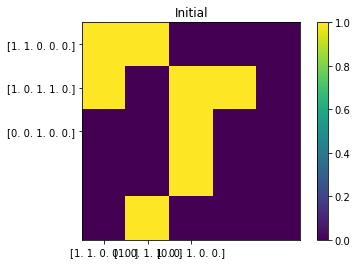

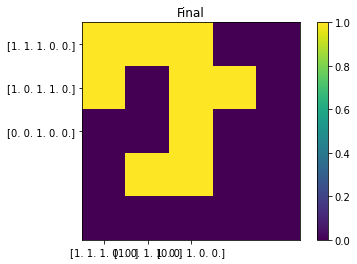

In [8]:
I=solution
N=neighbors(I,n)


c = len(I)
gol=md.Model(name='Game of Life')
x=np.array(gol.binary_var_list(n**2)).reshape(n,n)
H1 = np.sum([[ (3-N[i][j]*x[i,j]*(1-I[i][j]))**2 ] for i in range(n) for j in range(n)])
H2 = np.sum([[ (2.5-N[i][j]*x[i,j]*I[i][j])**2 ] for i in range(n) for j in range(n)])*100
H3 = np.sum([[ -(10-N[i][j]*x[i,j]*I[i][j])**2 ] for i in range(n) for j in range(n)])
gol.minimize(H1+H2+H3)
solution = np.array(gol.solve().get_value_list(x.flatten())).reshape(n,n)

#Plot
plt.imshow(I, interpolation='nearest',cmap='viridis')
plt.yticks([i for i in range(3)],I[:][:])
plt.xticks([i for i in range(3)],I[:][:])
plt.title('Initial')
plt.colorbar()
plt.show()

plt.imshow(solution, interpolation='nearest',cmap='viridis')
plt.yticks([i for i in range(3)],solution[:][:])
plt.xticks([i for i in range(3)],solution[:][:])
plt.title('Final')
plt.colorbar()
plt.show()

### Third iteration

[[ 0.   2.5 10.   2.5  0. ]
 [ 0.   2.5 10.  10.   0. ]
 [ 0.   0.   0.   2.5  2.5]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0. ]]


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


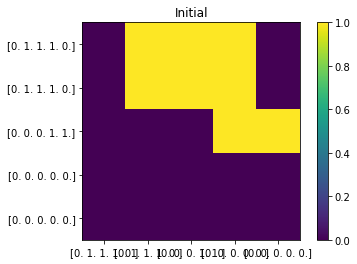

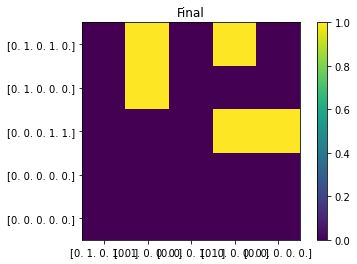

In [ ]:
I=solution
N=neighbors(I,n)
print(N)

c = len(I)
gol=md.Model(name='Game of Life')
x=np.array(gol.binary_var_list(n**2)).reshape(n,n)
H1 = np.sum([[ (3-N[i][j]*x[i,j]*(1-I[i][j]))**2 ] for i in range(n) for j in range(n)])
H2 = np.sum([[ (2.5-N[i][j]*x[i,j]*I[i][j])**2 ] for i in range(n) for j in range(n)])*100
H3 = np.sum([[ -(10-N[i][j]*x[i,j]*I[i][j])**2 ] for i in range(n) for j in range(n)])
gol.minimize(H1+H2+H3)
solution = np.array(gol.solve().get_value_list(x.flatten())).reshape(n,n)

#plot
plt.imshow(I, interpolation='nearest',cmap='viridis')
plt.yticks([i for i in range(n)],I[:][:])
plt.xticks([i for i in range(n)],I[:][:])
plt.title('Initial')
plt.colorbar()
plt.show()

plt.imshow(solution, interpolation='nearest',cmap='viridis')
plt.yticks([i for i in range(n)],solution[:][:])
plt.xticks([i for i in range(n)],solution[:][:])
plt.title('Final')
plt.colorbar()
plt.show()